# 2 Spectral Graph Theory

We'll see here two of the most celebrated algorithms stemming from Spectral Graph Theory:
1. [Spectral clustering](https://en.wikipedia.org/wiki/Spectral_clustering): clustering data using a similarity graphs
1. [Laplacian eigenmaps](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Laplacian_eigenmaps): dimensionality reduction which preserves geodesic distances

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pygsp import graphs
from additional_utils import AR_index, generate_concentric_circles
import networkx as nx
import sklearn
from sklearn import datasets, decomposition
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

## 2.1 The spectrum of a graph

We consider here only undirected graphs, such that the Laplacian matrix is real symmetric, thus diagonalizable in an orthonormal eigenbasis
$$\mathbf{L}=\mathbf{U}\mathbf{\Lambda U}^\top,$$
where $\mathbf{U}=(\mathbf{u}_1|\ldots|\mathbf{u}_N)\in\mathbb{R}^{N\times N}$ is the matrix of orthonormal eigenvectors and $\mathbf{\Lambda} = \text{diag}(\lambda_1,\ldots,\lambda_N)$ is the diagonal matrix of associated sorted eigenvalues:
$$\lambda_1\leq\lambda_2\leq\ldots\leq\lambda_N.$$

Recall that $\lambda_1$ is necessarily $0$ and that $\lambda_2>0$ iff the graph is connected. 

2018-09-14 03:28:24,731:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.23606797749979


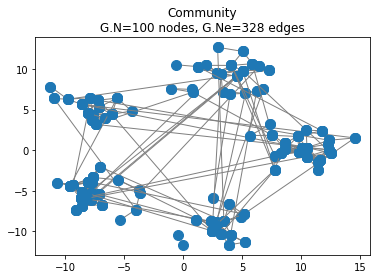

In [2]:
G = graphs.Community(N=100, Nc=5)
G.plot()
eig_val, U = sp.linalg.eigh(G.L.toarray()) 
# you obtain the same thing than if you had done G.compute_fourier_basis() and looked at G.e and G.U

Look at ``` eig_val```. Look at ```np.finfo(float).resolution```. How many connected components are in the graph? Check with the networkx function nx.connected_components ```G_nx = nx.from_numpy_matrix(G.A.toarray()); sorted(nx.connected_components(G_nx), key = len, reverse=True)```

Note that we used ```sp.linalg.eigh``` to diagonalize $\mathbf{L}$ because it is the eigensolver optimized for symmetric matrices. Also, ```sp.linalg.eigh``` cannot take sparse matrices as entries. For sparse matrices, optimized eigensolvers exist to obtain the first few eigenvalues and eigenvectors, such as 

In [3]:
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')

Use option ```which='SM'``` for smallest magnitude search, and ```which='LM'``` for largest magnitude search. ```eigsh``` is nevertheless only made to compute only a few eigenvectors. You will quickly see the utility of ```sp.sparse.linalg.eigsh(G.L, k=10, which='SM')``` versus ```sp.linalg.eigh(G.L.toarray())``` if you increase the size of the network to $10^4$ nodes or larger for instance.

## 2.2. The Stochastic Block Model (SBM)

The Stochastic Block Model (SBM) is a latent variable model of structured random graphs. 
* The set of $N$ nodes is partitioned in $k$ blocks $B_1, \ldots, B_k$ : $\cup_{i} B_i = \{1,\ldots,N\}$ and $\forall i\neq j, B_i\cap B_j = \emptyset$.
* We define a probability matrix $\mathbf{P}\in\mathbb{R}^{k\times k}$ such that $P_{ij}$ is the probability of connection between a node in $B_i$ and a node in $B_j$. 
* To generate an instance of SBM: for each pair of nodes in the graph, draw a Bernoulli random variable of parameter corresponding to their respective blocks.

To simplify, we will suppose that all intra-block probabilities are set to $p_{\text{in}}$ and all inter-block probabilities are set to $p_{\text{out}}$. Also, we will consider only balanced SBMs (ie SBMs whose blocks have same size).

In the case of balanced SBMs, instead of the pair of parameters $(p_{\text{in}}, p_{\text{out}})$, we can consider the pair $(c,\epsilon)$ where $c$ is the average degree of the graph and $\epsilon = \frac{p_{\text{out}}}{p_{\text{in}}}$ is a measure of fuzziness: the larger $\epsilon$, the fuzzier the community structure. The relations between both pairs of parameters are:
 $$p_{\text{in}} = \frac{kc}{N-k+(k-1)\epsilon N}~~~\text{ and }~~~p_{\text{out}} = \frac{kc\epsilon}{N-k+(k-1)\epsilon N}$$
Note that, for a fixed triplet $(\epsilon, N, k)$, $c$ is not a free parameter. 

**The classical inference SBM problem** is: given an instance of an SBM $G$, infer the blocks.

#### Impossibility threshold
In the balanced (ie: all blocks have the same size) and sparse (ie average degree $c=\mathcal{O}(1)$) case, the following phase transition has been shown ([Decelle et al.](https://arxiv.org/pdf/1109.3041.pdf), [Massoulié](https://arxiv.org/pdf/1311.3085.pdf), [Abbe et al.](https://arxiv.org/pdf/1503.00609.pdf)). For a given pair $(k, c)$, there exists a critical fuzziness $\epsilon_c$ such that as $N\rightarrow \infty$:
* if $\epsilon>\epsilon_c$, there exists no algorithm capable of extracting any structural information.
* if $\epsilon<\epsilon_c$, it is *theoretically* possible to retrieve some kind of structural information

with $\epsilon_c = \frac{c - \sqrt{c}}{c + \sqrt{c} (k-1)}$

In [4]:
N = 500; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

pin = (k * c) / (N - k + (k - 1) * epsi * N)
pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)

z = np.tile(np.arange(k), (np.int(N/k),1))
truth = np.reshape(z.T, (N,1))[:,0] # the ground truth community assignment truth[i] is the community number of node i

G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)

With ```epsi = epsi_c / 40```, ie, a very strong block structure, blocks appear even 'visually' with spring-based plotting algorithms:

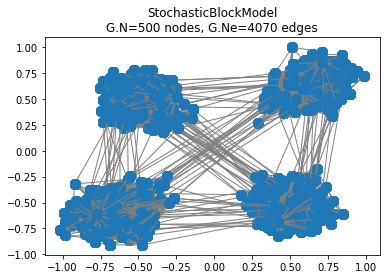

In [5]:
G.set_coordinates(kind='spring') #here with a spring based algorithm
G.plot()

## 2.3. The Eigengap

Let's look at the first few eigenvalues:

In [6]:
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=50, which='SM')

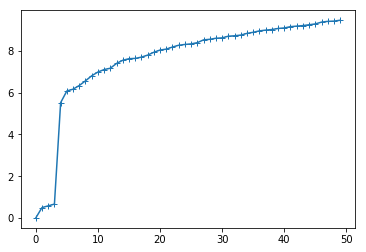

In [7]:
plt.plot(eig_val, '+-')

The large gap between $\lambda_k$ and $\lambda_{k+1}$ is called the "spectral gap": it heuristically appears when there is a strong structure in $k$ communities (even though there exist some theoretical justifications)

### Exercise: eigengap

* Plot a SBM graph with the spring-based plotting algorithm with $\epsilon=\epsilon_c/3$ for instance: one can no longer  extract communities 'visually' !
* Let's formally define the normalized spectral gap as $\Gamma = \frac{\lambda_{k+1}-\lambda_k}{\lambda_k}$. Plot the average of $\Gamma$ as a function of the fuziness $\epsilon$ in the case of balanced SBM graphs. 

## 2.4 The first few eigenvectors

We have seen that an eigengap usually exists in community-structured graphs. What can we say about the first few eigenvectors? 

Let's plot them in a balanced SBM graph:

In [8]:
N = 500; # number of nodes
k = 4; # number of blocks
c = 16; # average degree

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

pin = (k * c) / (N - k + (k - 1) * epsi * N)
pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)

z = np.tile(np.arange(k), (np.int(N/k),1))
truth = np.reshape(z.T, (N,1))[:,0] # the ground truth community assignment truth[i] is the community number of node i

G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)

In [9]:
eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')
G.set_coordinates(kind='spring')

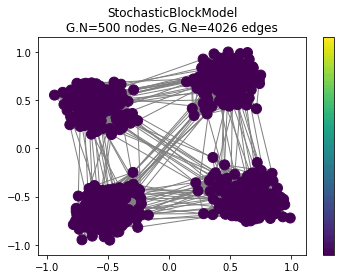

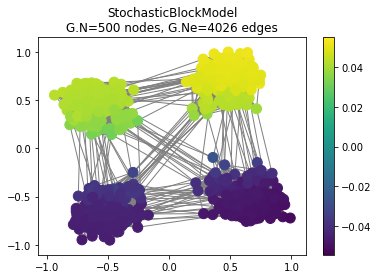

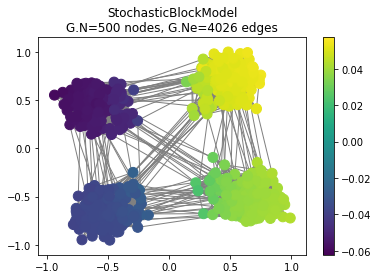

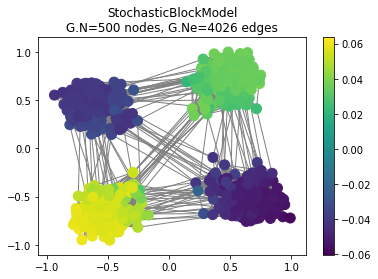

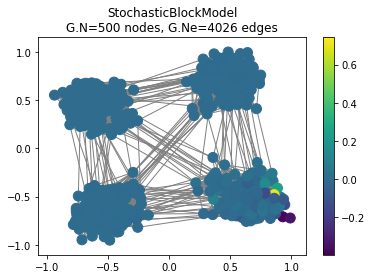

In [10]:
G.plot_signal(U[:,0])
G.plot_signal(U[:,1])
G.plot_signal(U[:,2])
G.plot_signal(U[:,3])
G.plot_signal(U[:,4])

**(Bonus question)** Why is the 5th eigenvector so localized?

Remember that:
$$\lambda_k=\mathbf{u}_k^\top\mathbf{L}\mathbf{u}_k=\sum_{i\sim j}\mathbf{W}_{ij} (u_k(i)-u_k(j))^2,$$
such that eigenvectors associated to low eigenvalues tend to be smooth with respect to any path in the network. In block-structured graphs, this usually means quasi-constant within each block. Also:
$$\mathbf{u}_2= \text{argmin}_{\mathbf{u}\in\mathbb{R}^N \text{  s.t.  }   \mathbf{u}_1^\top\mathbf{u}=0 \text{ and } \mathbf{u}^\top\mathbf{u}=1} ~~~\mathbf{u}^\top\mathbf{L}\mathbf{u}.$$
Because $\mathbf{u}_1=\frac{1}{\sqrt{N}}\mathbf{1}$ where $\mathbf{1}$ is the constant vector equal to $1$ (this is true in the case of the combinatorial Laplacian), this equation is equivalent to:
$$\mathbf{u}_2= \text{argmin}_{\mathbf{u}\in\mathbb{R}^N \text{s.t.} \sum_i u_2(i) = 0 \text{ and  }\sum_i u_2(i)^2 = 1} ~~~\mathbf{u}^\top\mathbf{L}\mathbf{u}.$$
In words: $\mathbf{u}_2$ is the normalized vector that minimizes local variation **AND** that has zero average. Similarly, $\mathbf{u}_3$ is the normalized vector that minimizes local variation **AND** that is orthogonal both to $\mathbf{u}_1$ and $\mathbf{u}_2$. Etc.

Spectral clustering takes advantage of this property. Let us look at a 3-block structure, for better illustration:

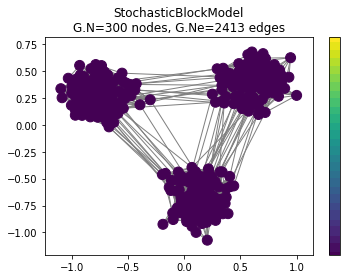

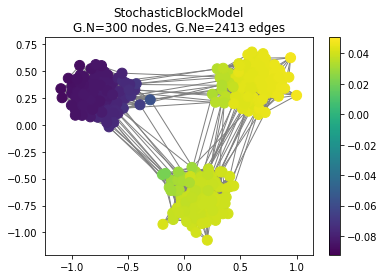

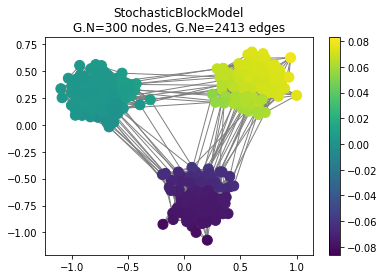

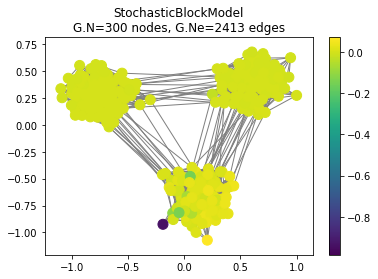

In [11]:
N = 300 # number of nodes
k = 3 # number of blocks
c = 16 # average degree

epsi_c = (c - np.sqrt(c)) / (c + np.sqrt(c) * (k-1)); # critical fuzziness
epsi = epsi_c / 40; # this is a very strong block structure

pin = (k * c) / (N - k + (k - 1) * epsi * N)
pout = (k * c * epsi) / (N - k + (k - 1) * epsi * N)

z = np.tile(np.arange(k), (np.int(N/k),1))
truth = np.reshape(z.T, (N,1))[:,0] # the ground truth community assignment truth[i] is the community number of node i

G = graphs.StochasticBlockModel(N=N, k=k, z=truth, p=pin, q=pout)

eig_val, U = sp.sparse.linalg.eigsh(G.L, k=10, which='SM')
G.set_coordinates(kind='spring')

G.plot_signal(U[:,0])
G.plot_signal(U[:,1])
G.plot_signal(U[:,2])
G.plot_signal(U[:,3])

Say we want to recover in which block belongs each node. The first eigenvector's information is useless (as long as we use the combinatorial Laplacian anyways) as it is constant. A solution is to plot each node $i$ in 2D with coordinates $(u_2(i), u_3(i))$:

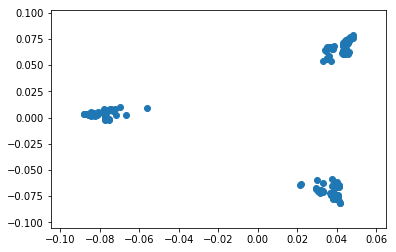

In [12]:
plt.figure()
plt.scatter(U[:,1], U[:,2])

Look at ```plt.scatter(U[:,1], U[:,2], c=G.truth)```: the nodes in the same block are in the same 'blob' in this 2D plot! This observation is the basis of spectral-clustering-type algorithms. 

### Exercise: spectral clustering

* Show that, in the last example, performing [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the $2D$ plane defined by $\mathbf{u}_2$ and $\mathbf{u}_3$ recovers the 3 block structures (the ground truth is in ```G.truth```). For $k$-means, use the function ```KMeans``` in the toolbox ```sklearn.cluster```. To measure performance, you can use the function ```AR_index``` which computes the [Adjusted Rand index](https://en.wikipedia.org/wiki/Rand_index) (both functions were already imported in the preamble)
* Given the intuition gained, write a general spectral clustering algorithm that takes as entry a graph $G$, a number of communities $k$, and outputs its community structure in $k$ blocks. 
* Plot the average performance of community mining with this spectral clustering algorithm on balanced SBMs versus the fuziness $\epsilon$. 
* To go further, you can read ["A tutorial on spectral clustering" by U. von Luxburg](https://arxiv.org/pdf/0711.0189.pdf). You will learn among other things that a degree-corrected version is in general preferable (using the normalized Laplacian instead of the combinatorial Lap for instance). For arguments to choose the "best" degree-correction, see ['Improved spectral community detection in large heterogeneous networks' by Tiomoko Ali and Couillet](http://www.jmlr.org/papers/volume18/17-247/17-247.pdf).

## 2.5 Creating the graph
We have seen the spectral clustering algorithm with inputs a graph $G$ and a number of desired clusters $k$. In many cases, however, the input data is simply $N$ vectors in dimension $d$. The construction of the graph is a problem in itself! Let us look at a toy point cloud example where spectral clustering is useful: two concentric circles. 

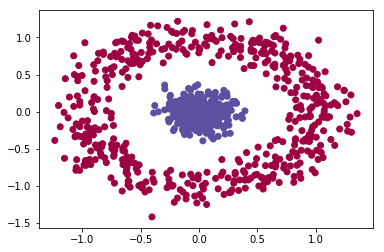

In [13]:
N_in=300 # number of nodes inside
N_out=500 # number of nodes outside
sigma_in= 0.15
sigma_out= 0.15
data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out, d=2)

plt.scatter(data[:,0], data[:,1], c=truth, cmap=plt.cm.Spectral)

$k$-means will obviously not work on this example. 

### Exercise: which similarity graph should one create from the data?
Look at Notebook 1 for the two main ways of creating a graph: $k$-nearest neighbours or $\epsilon$-proximity. 
* What is one of the main differences between the graphs created by these two techniques? (regarding the degree distribution for instance) 
* How does the performance change vs the choice of $k$ (the number of neighbours in the kNN graph)? 
* How does the perf change vs the choice of $\epsilon$ (in the $\epsilon$-graph)?

## 2.6 Laplacian eigenmaps

Consider the data 
$$\mathbf{X}=(\mathbf{x}_1|\mathbf{x}_2|\ldots|\mathbf{x}_N)^\top\in\mathbb{R}^{N\times d},$$
where each data point $\mathbf{x}_i$ lives in dimension $\mathbb{R}^d$. 

Laplacian eigenmaps are a non-linear dimension reduction technique that relies on the assumption that the data lives in a low-dimensional manifold of $\mathbb{R}^d$. Different from PCA applied directly on $\mathbf{X}$, Laplacian eigenmaps take into account the intrinsic geometry of the data by first building a similarity graph and then looking at the first few eigenvectors of its Laplacian matrix. One possible formulation of the problem is the following. 

**Problem.** Consider an embedding $~~f:\mathcal{V}\rightarrow \mathbb{R}^m$ and denote by $\mathbf{y}_i=f(i)\in\mathbb{R}^m$ the coordinates of node $i$ in the embedding space. The goal is to find an embedding such that points close to each other on the manifold are also close to each other in the embedded space, thus: an embedding preserving local distances on the manifold. 

**A solution** proposed by [Belkin and Niyogi](http://www.cs.rochester.edu/~stefanko/Teaching/09CS446/Laplacian.pdf) for an embedding in dimension $m$ is to
* first create a similarity graph (for instance via one of the two techniques in Notebook 1)
* compute the first $m+1$ right-eigenvectors of its random walk Laplacian matrix $(\mathbf{u}_0|\mathbf{u}_1|\ldots|\mathbf{u}_m)$. The random walk Laplacian matrix is defined as $$\mathbf{L}_{rw}=\mathbf{D}^{-1}\mathbf{L} = \mathbf{I}-\mathbf{D}^{-1}\mathbf{W}.$$
One can show by the way that the normalized Laplacian $\mathbf{L}_n =  \mathbf{I}-\mathbf{D}^{-1/2}\mathbf{W}\mathbf{D}^{-1/2}$ and the random walk Laplacian share the same eigenvalues and that $\mathbf{L}_n$'s eigenvectors and $\mathbf{L}_{rw}$'s right eigenvectors are connected via a simple transformation $\mathbf{u}_{rw}=\mathbf{D}^{-1/2}\mathbf{u}_n$.
* Embed each node $i$ via $\mathbf{y}_i=(u_1(i)|u_2(i)|\ldots|u_m(i))^\top\in\mathbb{R}^m$. In fact, $\mathbf{u_0}$ is constant thus useless for the embedding.

**Informal justification.** Let us write $$\mathbf{Y}=(\mathbf{y}_1^\top|\ldots|\mathbf{y}_N^\top)^\top\in\mathbb{R}^{N\times m}.$$
Once $\mathbf{W}$ is created, the idea is to find an embedding such that two points are close to each other in the embedding space if they are connected and far from each other if not. If $m=1$ this means finding $\mathbf{Y}$ such that $$\sum_{i\sim j}\mathbf{W}_{ij}(\mathbf{Y}_{i1}-\mathbf{Y}_{j1})^2=\mathbf{Y}^\top\mathbf{L}\mathbf{Y}$$ is minimized. The obvious solution to this problem is the constant vector (associated to eigenvalue $0$). To avoid such trivial solution, we enforce $\mathbf{Y}$ to be orthogonal to $\mathbf{1}$. The solution is thus $\mathbf{Y}=\mathbf{u}_2$.

**TODO** Find another high-dimensional example to compare PCA vs Laplacian eigenmaps embeddings?

Two toy graphs:

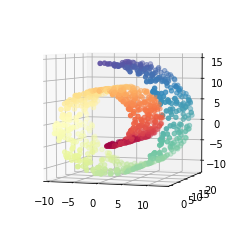

In [14]:
# Swiss Roll

Axes3D

n_points = 1000
X, color = datasets.make_swiss_roll(n_points, random_state=0)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

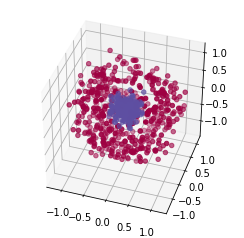

In [15]:
# two concentric spheres in 3D

X, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out, d=3)

Axes3D

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=truth, cmap=plt.cm.Spectral)
ax.view_init(40, -72)

### Exercise: PCA vs Laplacian eigenmaps
* Write the Laplacian eigenmaps algorithm and (at least visually) compare its embedding performance on the swiss roll dataset vs PCA embedding (both embeddings are in 2D). For PCA, use: ```decomposition.PCA```. To compute the first few eigenvectors of the random walk Laplacian, it is more efficient (and stable) to compute the first few eigenvectors of the normalized Laplacian via eigsh (because it is nicely symmetric), and then use $\mathbf{u}_{rw}=\mathbf{D}^{-1/2}\mathbf{u}_n$.
* Do the same with concentric data in 3D: ```data, truth = generate_concentric_circles(N_in, N_out, sigma_in, sigma_out, d=3)```

## 2.7 Laplacian Eigenmaps on real data

In [16]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

print(f"{n_samples} digits, {n_features} features")

1083 digits, 64 features


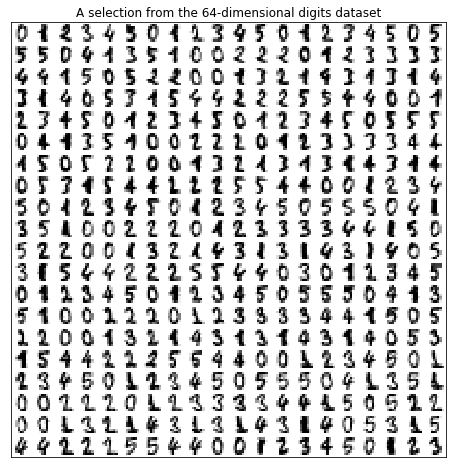

In [17]:
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.figure(figsize=(8,8))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');

Plot different 